In [1]:
'''
The fruit images for object detection dataset was used - https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection
'''

'\nThe fruit images for object detection dataset was used - https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection\n'

In [2]:
import zipfile
import os

zip_path = r'C:\Users\To Learn\Obj D\fruits.zip'
extract_folder = r'C:\Users\To Learn\Obj D\fruit'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

os.listdir(extract_folder)


['test_zip', 'train_zip']

In [3]:
import os

def list_files(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]
    xml_files = [f for f in os.listdir(folder_path) if f.endswith('.xml')]
    
    image_to_xml = {img: img.replace('.jpg', '.xml').replace('.png', '.xml') for img in image_files}
    return image_to_xml

train_folder = r'C:\Users\To Learn\Obj D\fruit\test_zip\test'
test_folder = r'C:\Users\To Learn\Obj D\fruit\train_zip\train'

train_image_to_xml = list_files(train_folder)
test_image_to_xml = list_files(test_folder)


In [4]:
import tensorflow as tf
import numpy as np
import cv2
import xml.etree.ElementTree as ET

def load_image(image_path):
    """Load an image from a file path and convert it to RGB format."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def preprocess_image(image, boxes):
    """Resize the image and normalize it. Also, resize boxes to match the new image size."""
    image = tf.image.resize(image, (640, 640))
    image = image / 255.0  # Normalize to [0, 1]
    return image, boxes

def parse_voc_annotation(xml_file):
    """Parse VOC XML annotation file to extract bounding boxes and labels."""
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    
    boxes = []
    labels = []
    
    for obj in root.findall('object'):
        label = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        boxes.append([ymin / height, xmin / width, ymax / height, xmax / width])
        labels.append(label)
    
    return np.array(boxes, dtype=np.float32), labels

def load_and_preprocess_image(image_path, xml_path):
    """Load an image and its annotation, preprocess them, and return them."""
    image = load_image(image_path)
    boxes, labels = parse_voc_annotation(xml_path)
    image, boxes = preprocess_image(image, boxes)
    
    return image, boxes


In [5]:
import tensorflow as tf
import numpy as np
import cv2
import xml.etree.ElementTree as ET

def _parse_image_file(img_file, xml_file):
    """Parse and process image and annotation files."""
    
    def process_file(img_file, xml_file):
        image_path = img_file.numpy().decode('utf-8')
        xml_path = xml_file.numpy().decode('utf-8')
        
        image, boxes = load_and_preprocess_image(image_path, xml_path)
        
        return image, boxes

    image, boxes = tf.py_function(func=process_file, inp=[img_file, xml_file], Tout=[tf.float32, tf.float32])
    
    image.set_shape((640, 640, 3))
    boxes.set_shape([None, 4])
    
    return image, boxes


In [6]:
def create_tf_dataset(image_to_xml):
    """Create a TensorFlow dataset from image and annotation file paths."""
    image_files = list(image_to_xml.keys())
    xml_files = [image_to_xml[img] for img in image_files]
    
    image_files = tf.constant(image_files, dtype=tf.string)
    xml_files = tf.constant(xml_files, dtype=tf.string)
    
    dataset = tf.data.Dataset.from_tensor_slices((image_files, xml_files))
    
    dataset = dataset.map(lambda img, xml: _parse_image_file(img, xml), num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.batch(1).prefetch(tf.data.AUTOTUNE)
    
    return dataset

In [7]:

train_image_to_xml = {
    r'C:\Users\To Learn\Obj D\fruit\test_zip\test\apple_77.jpg': r'C:\Users\To Learn\Obj D\fruit\test_zip\test\apple_77.xml',
    r'C:\Users\To Learn\Obj D\fruit\test_zip\test\banana_90.jpg': r'C:\Users\To Learn\Obj D\fruit\test_zip\test\banana_90.xml',
}

train_dataset = create_tf_dataset(train_image_to_xml)

for image, boxes in train_dataset.take(1):
    print("Image shape:", image.shape)
    print("Boxes shape:", boxes.shape)
    print("Boxes:", boxes.numpy())


Image shape: (1, 640, 640, 3)
Boxes shape: (1, 5, 4)
Boxes: [[[0.26200873 0.23666666 0.7161572  0.5833333 ]
  [0.09606987 0.04       0.48471615 0.35      ]
  [0.10043668 0.44666666 0.5021834  0.81      ]
  [0.55021834 0.35666665 1.         0.72      ]
  [0.60262007 0.69       1.         0.99333334]]]


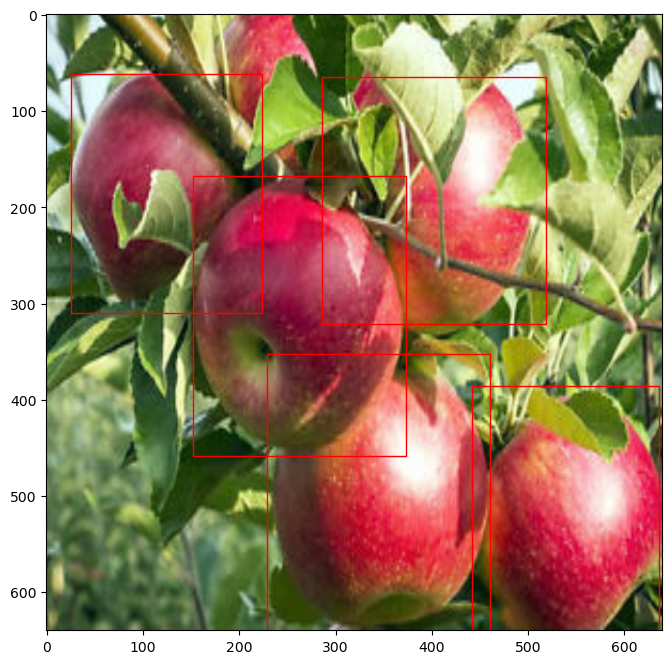

In [8]:
import matplotlib.pyplot as plt

def visualize_image_with_boxes(image, boxes):
    plt.figure(figsize=(8, 8))
    image = image.numpy().squeeze()
    plt.imshow(image)
    
    boxes = boxes.numpy().squeeze() 
    for box in boxes:
        ymin, xmin, ymax, xmax = box
        ymin, xmin, ymax, xmax = ymin * image.shape[0], xmin * image.shape[1], ymax * image.shape[0], xmax * image.shape[1]
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor='r', facecolor='none'))
    
    plt.show()

for image, boxes in train_dataset.take(1):
    visualize_image_with_boxes(image, boxes)


In [9]:
def get_image_and_boxes(dataset, index):
    dataset_list = list(dataset.as_numpy_iterator())
    if index >= len(dataset_list):
        raise ValueError("Index out of range")
    batch = dataset_list[index]
    image, boxes = batch
    image = image[0]
    boxes = boxes[0]
    return image, boxes

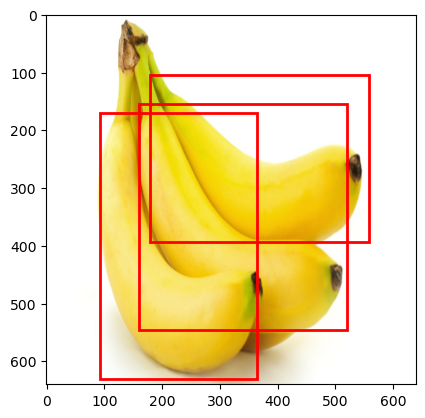

In [10]:
import matplotlib.pyplot as plt

def visualize_image_with_boxes(image, boxes):
    image = (image * 255).astype(np.uint8)

    plt.imshow(image)
    
    height, width, _ = image.shape
    
    for box in boxes:
        ymin, xmin, ymax, xmax = box
        xmin, xmax = xmin * width, xmax * width
        ymin, ymax = ymin * height, ymax * height
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                             fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
    
    plt.show()

second_image, second_boxes = get_image_and_boxes(train_dataset, 1)

visualize_image_with_boxes(second_image, second_boxes)
